In [1]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns

"""
# Examples - top causal 
causal = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table", sep="\t")
causal = causal[causal["top.variant"].apply(lambda x: "SNP" not in x)]
causal = causal.sort_values("best.score", ascending=False)

num = 100
GENES = list(causal["gene"])[0:num]
CHROMS = list(causal["chrom"].apply(lambda x: x[3:]))[0:num]
STARTS = list(causal["best.str.start"])[0:num]
TISSUES = list(causal["best.tissue"])[0:num]
"""

# Examples - near TSS
"""
num = 100
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes.tab"), sep="\t")
data = data[data["dist.to.tss"].apply(abs)<=1000]
data = data.sort_values("dist.to.tss")
data = data.head(n=num)
GENES = list(data["gene"])
TISSUES = list(data["best.tissue"])
STARTS = list(data["best.str.start"])
CHROMS = list(data["chrom"])
QVALS = list(data["best.q"])
"""
GENES=["ENSG00000141096.4"]
CHROMS=["16"]
STARTS=[68014740]
QVALS=[None]
TISSUES=["Lung"]

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral(Omentum)":"orange",
    "Brain-Caudate(basalganglia)":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed(Suprapubic)":"blue",
    "Skin-SunExposed(Lowerleg)":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def PlotESTR(gene, tissue, chrom, start, COLORS):
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s"%(chrom, start, gene))
    plt.suptitle("");
    plt.show()
    fig.savefig("%s_estr.pdf"%gene)

def PlotHeatmap():
    strgt = pd.read_csv("str_genotypes_alleles.tab", sep="\t", names=["sample","GB"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    strgt["str"] = strgt["GB"].apply(lambda x: sum([int(item) for item in x.split(",")]))
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    correxpr = pd.merge(strgt, expr)
    # Heatmap
    alleles = set()
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        alleles.add(int(a1))
        alleles.add(int(a2))
    alleles = sorted(list(alleles))

    exprmatrix = np.zeros((len(alleles), len(alleles)))
    counts = np.zeros((len(alleles), len(alleles)))
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        a1 = int(a1)
        a2 = int(a2)
        if a1<a2:
            a1ind = alleles.index(a1)
            a2ind = alleles.index(a2)
        else: 
            a1ind = alleles.index(a2)
            a2ind = alleles.index(a1)
        exprmatrix[a1ind,a2ind] += correxpr["expr"].values[i]
        exprmatrix[a2ind,a1ind] += correxpr["expr"].values[i]
        counts[a1ind,a2ind] += 1
        counts[a2ind,a1ind] += 1
    exprmatrix = exprmatrix/(counts+1)

    sns.heatmap(exprmatrix, xticklabels=alleles, yticklabels=alleles)
    
    # Plot each row of the matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(exprmatrix.shape[0]):
        vals = exprmatrix[i,:]
        if sum(counts[i,:]) < 25: continue
        nvals = []
        for item in vals:
            if item == 0: nvals.append(None)
            else: nvals.append(item)
        ax.plot(alleles, nvals, label=alleles[i])
    ax.legend()

ENSG00000141096.4,16,68014740,Lung None


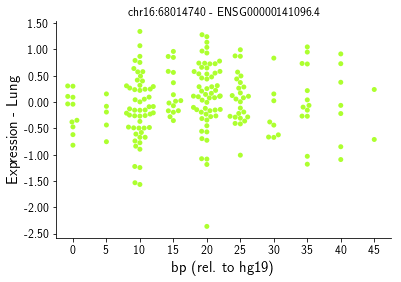

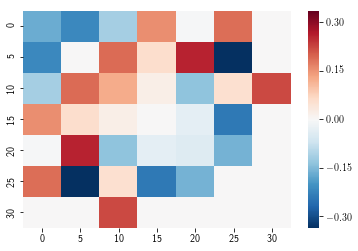

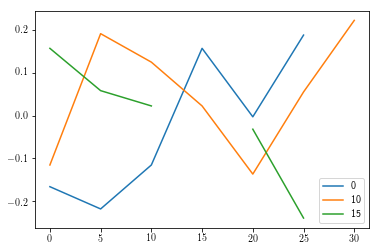

In [3]:
for i in range(len(GENES)):
    print("%s,%s,%s,%s %s"%(GENES[i], CHROMS[i], STARTS[i], TISSUES[i], QVALS[i]))
    ExtractData(GENES[i], CHROMS[i].replace("chr",""), STARTS[i], TISSUES[i])
    PlotESTR(GENES[i], TISSUES[i], CHROMS[i].replace("chr",""), STARTS[i], COLORS)
    PlotHeatmap()